K-fold Cross Validation

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style


In [2]:

MODEL_NAME = f"model-{time.asctime()}"  # gives a dynamic model name, to just help with things getting messy over
# time.

BATCH_SIZE = 100
k=5
EPOCHS = 5

In [3]:
REBUILD_DATA = False  # set to true to one once, then back to false unless you want to change something in your


In [4]:

# training data.


class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[
                            self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot
                        # print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        # print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:', dogsvcats.catcount)
        print('Dogs:', dogsvcats.dogcount)


In [5]:
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
#        self.bn1 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(32, 64, 5)
#        self.bn2 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.bn1 = nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.AlphaDropout(p=0.3)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

        '''>>> # With Learnable Parameters
        >>> m = nn.BatchNorm2d(100)
        >>> # Without Learnable Parameters
        >>> m = nn.BatchNorm2d(100, affine=False)
        >>> input = torch.randn(20, 100, 35, 45)
        >>> output = m(input)'''

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        x = self.dropout(x)
        return F.softmax(x, dim=1)

In [8]:
net = Net().to(device)

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler 
# help(SubsetRandomSampler)

In [10]:
data = np.load("training_data.npy", allow_pickle=True)
print(len(data))

24998


In [11]:
train_data = torch.Tensor([i[0] for i in data]).view(-1, 50, 50) 
train_data = train_data / 255.0

print(train_data.size())
test_data = torch.Tensor([i[1] for i in data])

torch.Size([24998, 50, 50])


In [12]:
train_sampler = SubsetRandomSampler(list(range(int(len(data)*0.8+1))))
valid_sampler = SubsetRandomSampler(list(range(int(len(data)*0.2))))

print(int(len(data)*0.8), int(len(data)*0.2), int(len(data)*0.2)+int(len(data)*0.8))

19998 4999 24997


In [13]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, sampler= train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, sampler= valid_sampler)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE)

In [14]:
print(len(test_loader.sampler),len(train_loader.sampler), len(valid_loader.sampler))

24998 19999 4999


In [15]:
print(len(list(iter(train_loader))))# 200 batches of size 100, (one is 99)

200


In [16]:
print(len(list(iter(test_loader))))# 250 batches of size 100, (one is 98)

250


In [17]:
print(len(list(iter(valid_loader))))# 50 batches of size 100, (one is 99)

50


In [18]:
"""VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]"""

In [39]:
def CrossValidation(net):
    for i in range(k):
        valid_sampler = SubsetRandomSampler(list(range(int(len(data)*0.2))))
        valid_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE)
            #print(list(iter(valid_loader)))

        train_sampler = SubsetRandomSampler(list(range(int(len(data)*0.8+1))))
        train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE)

        test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE)

        with open("model_new.log", "a") as f:
            for epoch in tqdm(range(EPOCHS)):
                    batch_X = next(iter(train_loader)).view(-1, 1, 50, 50)
                    batch_y = next(iter(test_loader))

                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                    acc, loss = fwd_pass(batch_X, batch_y, train_=True)

                    batch_val = next(iter(valid_loader)).view(-1,1,50,50)
                    batch_val = batch_val.to(device)
                    val_acc, val_loss = fwd_pass(batch_val, batch_y)

                        # print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                        # f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                        # just to show the above working, and then get out:
                    f.write(
                            f"{MODEL_NAME},{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},"
                            f"{round(float(val_acc), 2)},{round(float(val_loss), 4)},{epoch}\n")



In [40]:

def create_acc_loss_graph(model_name):
    contents = open("model_new.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

    fig = plt.figure()

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

In [41]:
#parameters
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [42]:
def fwd_pass(X_, y_, train_=False):
    if train_:
        net.zero_grad()

    outputs = net(X_)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y_)]
    acc = matches.count(True) / len(matches)
    loss = loss_function(outputs, y_)

    if train_:
        loss.backward()
        optimizer.step()

    return acc, loss

In [43]:
style.use("ggplot")

print(MODEL_NAME)


model-Fri Jul 17 04:01:46 2020


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


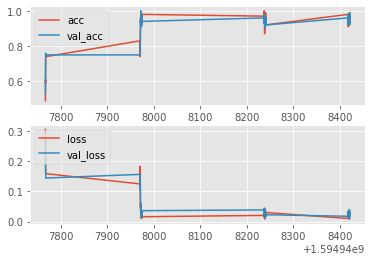

In [45]:
CrossValidation(net)
create_acc_loss_graph(MODEL_NAME)

In [50]:
test_X = train_data[-100:].view(-1, 1, 50, 50)
test_y = test_data[-100:]

test_X, test_y = test_X.to(device), test_y.to(device)

final_acc, final_loss = fwd_pass(test_X, test_y)


In [52]:
print(final_acc,":)", final_loss)

0.58 :) tensor(0.3683, device='cuda:0', grad_fn=<MseLossBackward>)


In [ ]:
#help(random_split)
a = torch.arange(10).reshape(5,2)
#b = random_split(a, [5])
#c1, c2 = torch.split(a, [2,3])
#print(a[:1],":)", a[1:])
print(a)

In [ ]:
for i in range(2):
    valid_sampler = SubsetRandomSampler(list(range(int(4))))
    train_sampler = SubsetRandomSampler(list(range(int(2))))
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size = 10, sampler= valid_sampler)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = 1, sampler= train_sampler)
    print(next(iter(valid_loader)))
    print(":)")
    # print((train_loader))
    print(":(")